# Laboratorio: Reti Neurali con Keras

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

- Per questa esercitazione utilizziamo
  - **Keras** come API di alto livello per la costruzione e l'addestramento di reti neurali
  - **TensorFlow** come backend per la computazione da utilizzare attraverso Keras
- Se si lavora sul proprio PC, installare le librerie con `conda` oppure `pip`
  - su Colab sono già installate

In [1]:
# se si utilizza Anaconda:
#%conda install tensorflow keras

In [2]:
# altrimenti:
#%pip install keras

- Importare le librerie per verificarne il funzionamento

In [3]:
import tensorflow as tf
import keras

Using TensorFlow backend.


- Importiamo le altre librerie di uso comune

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

- Definiamo la seguente funzione di supporto per scaricare i file di dati necessari

In [5]:
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Ripasso: Reti neurali

- Una _rete neurale_ è un modello di apprendimento costituito da molteplici strati di nodi elementari
- Ciascun nodo è in pratica un modello di regressione, i cui input sono forniti dallo strato precedente e il cui output è passato a quello successivo
  - per modellare relazioni non lineari si applicano agli output dei nodi delle _funzioni di attivazione_, ad es. la funzione _ReLU_
- Tramite la _backpropagation_, i parametri (pesi e bias) di tutti i nodi sono addestrati congiuntamente per ottimizzare l'errore della rete tramite discesa gradiente stocastica
  - il training set è iterato molteplici volte (_epoche_), ad ogni iterazione le istanze vengono considerate a gruppi (_minibatch_)
- Ci sono molti aspetti configurabili (_iperparametri_) nella configurazione e nell'addestramento di una rete
  - struttura della rete: numero di strati, numero di nodi in ciascuno, funzione di attivazione, ...
  - addestramento: batch size, numero di epoche, ...

## Esempio: Classi non separabili linearmente

- Riprendiamo l'esempio della classificazione di punti nel piano con classi non separabili linearmente
  - sia training che validation set contengono le coordinate di punti in un piano, distribuiti in due diverse corone circolari
  - vogliamo addestrare un modello di classificazione a distinguere i punti interni da quelli esterni

In [6]:
from sklearn.datasets import make_circles
X_train, y_train = make_circles(1000, noise=0.1, factor=0.5, random_state=23)
X_val, y_val = make_circles(1000, noise=0.1, factor=0.5, random_state=42)

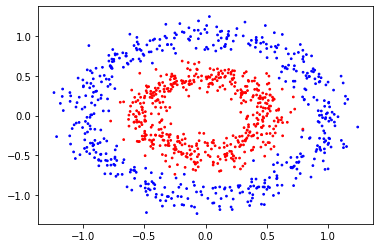

In [7]:
plt.scatter(*X_train.T, s=3, c=np.where(y_train, "red", "blue"));

- Riprendiamo la funzione che, dato un modello, visualizza come questo classifica i punti nel piano

In [8]:
def plot_class_model(X, y, model):
    plt.scatter(X[:, 0], X[:, 1])
    xlim, ylim = plt.xlim(), plt.ylim()
    mx = np.linspace(xlim[0], xlim[1], 101)
    my = np.linspace(ylim[0], ylim[1], 101)
    mx, my = np.meshgrid(mx, my)
    mz = model.predict_proba(np.c_[mx.ravel(), my.ravel()])[:, 1].reshape(mx.shape)
    plt.contourf(mx, my, mz, cmap="cool")
    plt.scatter(X[:, 0], X[:, 1], c=np.where(y, "#880000", "blue"), s=4)

- Abbiamo visto che un modello lineare non può essere addestrato efficacemente a distinguere le due classi per via della non linearità

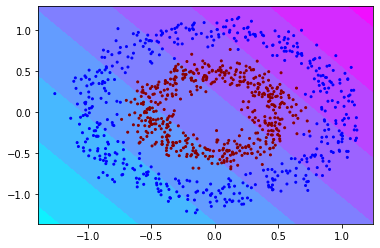

In [9]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)
model.fit(X_train, y_train)
plot_class_model(X_val, y_val, model)

- Se introduciamo manualmente i quadrati delle variabili, otteniamo un modello efficace

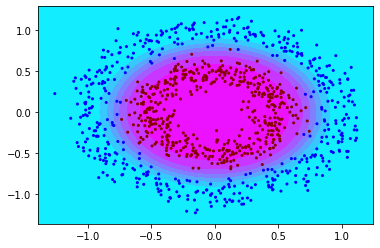

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LogisticRegression(solver="saga", random_state=42))
])
model.fit(X_train, y_train)
plot_class_model(X_val, y_val, model)

- Abbiamo però visto come con una rete neurale, senza generare manualmente delle variabili, otteniamo lo stesso risultato
- Consideriamo ad esempio una rete
  - costituita da un singolo strato nascosto di 32 nodi con attivazione ReLU
    - $\text{ReLU}(x)=\max(0,x)$
  - addestrata con discesa gradiente stocastica (SGD) per 100 epoche a minibatch di 200 istanze

In [11]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(
    hidden_layer_sizes=[32],
    activation="relu",
    solver="sgd",
    max_iter=100,
    batch_size=200,
    random_state=123
)
model.fit(X_train, y_train);

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


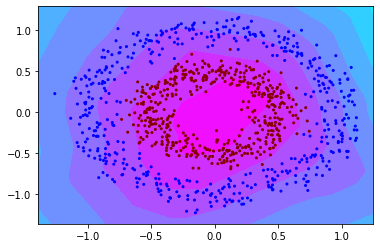

In [12]:
plot_class_model(X_val, y_val, model)

In [13]:
model.score(X_val, y_val)

0.955

- La rete ha sfruttato i nodi per approssimare quanto meglio possibile la distribuzione delle classi

## Regressione con reti neurali

- Abbiamo visto l'utilizzo di una rete neurale in un problema di classificazione
- Le reti neurali sono però in primis modelli di regressione, in quanto forniscono in output un valore reale (o più d'uno)
  - nel caso della classificazione, la rete viene implicitamente addestrata a prevedere le probabilità di ciascuna classe (come vedremo sotto)
- Vediamo un esempio concreto di uso di una rete neurale in un problema di regressione

- Riprendiamo il problema della predizione dei consumi elettrici in base alla temperatura
- Carichiamo il dataset in un frame pandas

In [14]:
download("power.csv", "https://git.io/vpaM1")
data = pd.read_csv("power.csv", index_col="date", parse_dates=["date"])

In [15]:
data.head(5)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


- Dal grafico a dispersione, vediamo che anche in questo caso la relazione tra i dati è non lineare

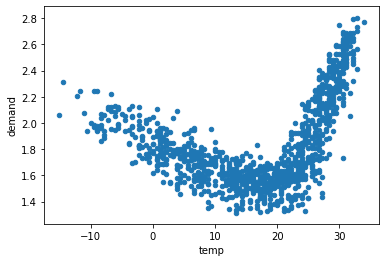

In [16]:
data.plot.scatter("temp", "demand");

- Come in precedenza consideriamo
  - i dati del 2015 e del 2016 come training set
  - quelli del 2017 come validation set

In [17]:
data_train = data.loc[data.index.year < 2017]
data_val = data.loc[data.index.year >= 2017]

- Per ogni set estraiamo
  - le temperature registrate (variabile indipendente x)
  - i consumi (variabile dipendente y)

In [18]:
is_train = data.index.year < 2017
X_train = data.loc[is_train, ["temp"]]
y_train = data.loc[is_train, "demand"]
X_val = data.loc[~is_train, ["temp"]]
y_val = data.loc[~is_train, "demand"]

- Eseguiamo la standardizzazione sia delle X che delle y
  - non utilizziamo una pipeline per analizzare meglio i passaggi

In [19]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train[:, None]).ravel()
y_val = y_scaler.transform(y_val[:, None]).ravel()

- Per addestrare un modello di regressione basato su rete neurale, utilizziamo la classe `MLPRegressor`
- Questa classe supporta gli stessi iperparametri di `MLPClassifier`
- Definiamo ad esempio una rete con 4 nodi nascosti con attivazione ReLU

In [20]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(
    hidden_layer_sizes=[4],
    activation="relu",
    solver="sgd",
    random_state=12345
)

- Addestriamo il modello come al solito

In [21]:
model.fit(X_train, y_train);

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [22]:
model.score(X_val, y_val)

0.6511894492150871

- Definiamo una funzione per visualizzare le predizioni del modello sovrapposte ai dati

In [23]:
def plot_regr_model(X, y, model):
    plt.scatter(np.array(X)[:, 0], y)
    xlim, ylim = plt.xlim(), plt.ylim()
    mx = np.linspace(*xlim, 100)[:, None]
    my = model.predict(mx)
    plt.plot(mx, my, c="red", lw=3)
    plt.xlim(xlim); plt.ylim(ylim)

- Usiamola per visualizzare il modello addestrato

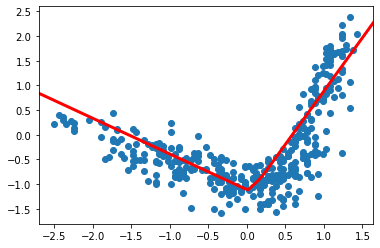

In [24]:
plot_regr_model(X_val, y_val, model)

- Con i nodi ReLU abbiamo ottenuto in pratica una funzione "spezzata"

## Reti neurali con Keras

- Abbiamo visto il supporto basilare offerto da scikit-learn per addestrare reti neurali
- Vediamo ora come utilizzare la libreria Keras, che offre
  - maggiore configurabilità delle reti, con la possibilità di definirne nel dettaglio ciascuno strato
  - maggiore efficienza, utilizzando backend come TensorFlow con possibilità di utilizzo della GPU

## Modello di regressione con Keras

- Continuiamo a considerare il problema di predizione dei consumi, per cui ci serve un modello di regressione
- Un modello _sequenziale_ di Keras è definito da una sequenza (senza diramazioni, cicli, ecc.) di strati connessi
  - il primo strato riceve l'input dato alla rete
  - ogni strato propaga l'output allo strato successivo
  - l'ultimo strato fornisce l'output della rete
- Si definisce con un oggetto `Sequential` definendo la lista di strati
- Il tipo di strato più comune è `Dense`, in cui ogni nodo riceve input da tutti i nodi dello strato precedente

In [25]:
from keras.models import Sequential
from keras.layers import Dense

- Per iniziare, creiamo una "rete" con un singolo strato e un singolo nodo
- Su ogni strato `Dense` dobbiamo indicare il numero di nodi
- Inoltre sul primo strato dobbiamo indicare con `input_dim` il numero di valori in input, in questo caso due (le coordinate di ciascun punto)

In [26]:
model = Sequential([
    Dense(1, input_dim=1)
])

- L'output della rete sarà il valore restituito dal singolo nodo
  - questo è in pratica un semplice modello di regressione lineare univariata

- Col metodo `summary` vediamo un riepilogo degli strati della rete

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


- La `Output shape` indica la forma dell'output di ciascuno strato
  - il primo termine (`None`) si riferisce al numero di osservazioni in ciascun minibatch, al momento non specificato
  - il secondo termine (1) è dato dal numero di nodi specificato
- `Param #` indica il numero di parametri che saranno addestrati
  - in questo caso solamente 2: 1 peso w e 1 bias b ($y=w\cdot x+b$)

- Una volta definita la struttura della rete questa va _compilata_ per costruirne il grafo computazionale su TensorFlow
- Quando si compila la rete va specificato un algoritmo di ottimizzazione (`optimizer`) da utilizzare per addestrare la rete
  - si possono usare diverse varianti della discesa gradiente stocastica
- Va inoltre specificata la misura di errore (`loss`) da minimizzare nell'addestramento
  - per la regressione usiamo l'errore quadratico medio

In [28]:
model.compile(optimizer="adam", loss="mean_squared_error")

- Ora possiamo addestrare la rete sul training set, usando il metodo `fit` come in scikit-learn
  - passiamo la matrice X con variabili indipendenti e il vettore y con variabile dipendente da predire
- Nella discesa gradiente stocastica gli esempi di training sono presi a gruppi di dimensione pari ad una `batch_size` indicata
- L'intero training set viene scorso in ordine casuale per un numero cicli di addestramento, detti _epoche_ (`epochs`)

In [29]:
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=20)

Epoch 1/20
731/731 [==============================] - 0s 264us/step - loss: 0.8739
Epoch 2/20
731/731 [==============================] - 0s 194us/step - loss: 0.8653
[...]
731/731 [==============================] - 0s 177us/step - loss: 0.8579
Epoch 20/20
731/731 [==============================] - 0s 182us/step - loss: 0.8581


- Durante l'addestramento, l'errore sul training set, mostrato come `loss`, si riduce progressivamente
- L'andamento di epoca in epoca viene salvato nell'oggetto `fit_history`, possiamo visualizzarlo in un grafico

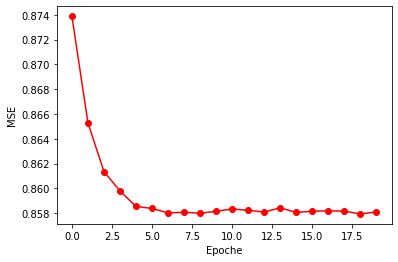

In [30]:
plt.plot(fit_history.history["loss"], "ro-")
plt.xlabel("Epoche")
plt.ylabel("MSE");

- Una volta addestrato, possiamo ottenere predizioni dal modello col metodo `predict` come in scikit-learn
- Otteniamo ad esempio le predizioni per il validation set

In [31]:
y_pred = model.predict(X_val)
y_pred[:3]

array([[-0.35205418],
       [-0.29693788],
       [-0.25904545]], dtype=float32)

- Si noti che i valori restituiti dal modello sono standardizzati sulla stessa scala usata nell'addestramento
- Possiamo usare il metodo `inverse_transform` del filtro per "destandardizzare" i valori riportandoli alla scala originale

In [32]:
y_scaler.inverse_transform(model.predict(X_val[:3]))

array([[1.7412814],
       [1.7602098],
       [1.7732232]], dtype=float32)

- Il metodo `evaluate` esegue una valutazione su un validation set e restituisce la misura d'errore usata in addestramento (il MSE)

In [33]:
model.evaluate(X_val, y_val)

365/365 [==============================] - 0s 27us/step


0.6914047678856

- Questa misura può essere confrontata tra diversi modelli
- Per ottenere una misura più generale dell'errore possiamo estrarre il coefficiente R²

In [34]:
from sklearn.metrics import r2_score
r2_score(
    y_scaler.inverse_transform(y_val),
    y_scaler.inverse_transform(y_pred)
)

0.0270893845768031

- Data la definizione di R², otteniamo lo stesso risultato confrontando gli output standardizzati

In [35]:
r2_score(y_val, y_pred)

0.027089451743842696

- Il punteggio R² è prossimo allo 0, molto scarso
- Questo è dovuto al fatto che il modello lineare non può modellare correttamente la relazione non lineare, come mostrato dal grafico del modello

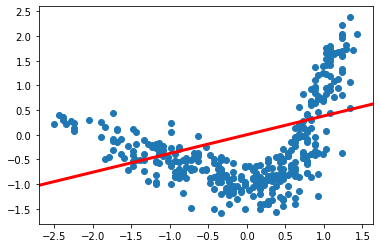

In [36]:
plot_regr_model(X_val, y_val, model)

## Aggiungere uno strato

- Aggiungiamo ora al modello uno strato nascosto - ad es. di 8 nodi - a cui viene passato l'input
- Per introdurre non linearità, a questo strato applichiamo la funzione di attivazione ReLU
- Siano
  - $w^{(l)}_{i,j}$ il peso della connessione dal nodo $i$ dello strato $l-1$ al nodo $j$ dello strato $l$
  - $b^{(l)}_j$ il bias applicato sul nodo $j$ dello strato $l$
- Ogni nodo dello strato nascosto $i$ fornirà come output:
$$ h_i = \text{ReLU}\left(b^{(1)}_i + w^{(1)}_{1,i}\cdot x\right) $$
- A sua volta l'output sarà una combinazione di questi 16 nodi:
$$ y = b^{(2)}_1 + \sum_{i=1}^{8}{w^{(2)}_{i1}\cdot h_i} = b^{(2)}_1 + \sum_{i=1}^{8}{w^{(2)}_{i,1}\cdot\text{ReLU}\left(b^{(1)}_i + w^{(1)}_{1,i}\cdot x\right)} $$

- Creiamo un nuovo modello `Sequential` con uno strato `Dense` aggiunto con attivazione "relu"
  - lo strato in output ha sempre 1 nodo con attivazione lineare (default)

In [37]:
model = Sequential([
    Dense(8, activation="relu", input_dim=1),
    Dense(1)
])

- Eseguiamo la compilazione come sopra

In [38]:
model.compile(optimizer="adam", loss="mean_squared_error")

- Dal sommario vediamo che il modello ha 25 parametri addestrabili, ovvero
  - gli 8 pesi $w^{(1)}_{1,j}$ dati all'input ai nodi dello strato nascosto
  - gli 8 bias $b^{(1)}_j$ dei nodi dello strato nascosto
  - gli 8 pesi $w^{(2)}_{i,1}$ dati all'output dello strato nascosto dal nodo di output
  - il bias $b^{(2)}_1$ del nodo di output

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


- Eseguiamo il training del modello mantenendo le stesse impostazioni

In [40]:
fit_history = model.fit(X_train, y_train, batch_size=3, epochs=20)

Epoch 1/20
731/731 [==============================] - 0s 327us/step - loss: 0.5819
Epoch 2/20
731/731 [==============================] - 0s 229us/step - loss: 0.4027
[...]
731/731 [==============================] - 0s 215us/step - loss: 0.1792
Epoch 20/20
731/731 [==============================] - 0s 213us/step - loss: 0.1785


- Vediamo già durante il training che la _loss_ (il MSE sul training set) è scesa di più rispetto alla rete precedente

- Grafichiamo come sopra l'andamento del MSE durante il training

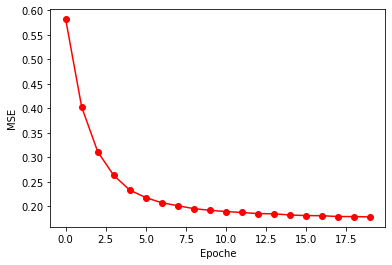

In [41]:
plt.plot(fit_history.history["loss"], "ro-")
plt.xlabel("Epoche")
plt.ylabel("MSE");

- Calcoliamo MSE e R² sul validation set

In [42]:
model.evaluate(X_val, y_val)

365/365 [==============================] - 0s 31us/step


0.19660624653509218

In [43]:
r2_score(y_val, model.predict(X_val))

0.7233454269072286

- Grazie alla combinazione di nodi non lineari abbiamo ottenuto un modello nettamente migliore, come visibile anche dal grafico

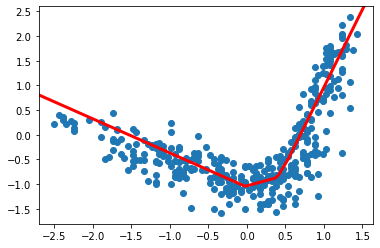

In [44]:
plot_regr_model(X_val, y_val, model)

- Col metodo `get_weights` possiamo ottenere i parametri del modello, scomposti in questo caso in
  - una matrice 1x8 con i pesi dello strato nascosto
  - un vettore con gli 8 bias dello strato nascosto
  - una matrice 8x1 con i pesi del nodo di output
  - un vettore con il bias del nodo di output

In [45]:
model.get_weights()

[array([[-0.01818765,  0.973737  ,  0.94327474, -0.65290964, -0.6461512 ,
          1.0369418 , -0.18399023, -0.24087468]], dtype=float32),
 array([ 0.28252292, -0.39828292, -0.51522505, -0.01375546, -0.01247599,
        -0.39025655,  0.3272939 ,  0.36197802], dtype=float32),
 array([[-0.38726014],
        [ 1.1471246 ],
        [ 0.5813303 ],
        [ 0.90819216],
        [ 0.81579137],
        [ 1.021597  ],
        [-0.9548521 ],
        [-1.019751  ]], dtype=float32),
 array([-0.24495669], dtype=float32)]

## Esercizio 1: Regressione in Keras

- **(1a)** Definire, addestrare e calcolare R² di un modello a rete neurale come quello sopra ma con 32 nodi nello strato nascosto invece di 8
- **(1b)** Definire, addestrare e calcolare R² di un modello a rete neurale con due strati nascosti rispettivamente di 32 e 8 nodi, entrambi con attivazione ReLU
- Quesito: quanti parametri addestrabili ha ciascuno di questi due modelli? (rispondere senza utilizzare `summary`)

In [47]:
model = Sequential([
    Dense(32, activation="relu", input_dim=1),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, batch_size=3, epochs=10)
r2_score(y_val, model.predict(X_val))

Epoch 1/10
731/731 [==============================] - 0s 282us/step - loss: 0.7639
Epoch 2/10
731/731 [==============================] - 0s 216us/step - loss: 0.4329
Epoch 3/10
731/731 [==============================] - 0s 208us/step - loss: 0.2938
Epoch 4/10
731/731 [==============================] - 0s 207us/step - loss: 0.2368
Epoch 5/10
731/731 [==============================] - 0s 208us/step - loss: 0.2154
Epoch 6/10
731/731 [==============================] - 0s 226us/step - loss: 0.2015
Epoch 7/10
731/731 [==============================] - 0s 233us/step - loss: 0.1916
Epoch 8/10
731/731 [==============================] - 0s 219us/step - loss: 0.1871
Epoch 9/10
731/731 [==============================] - 0s 242us/step - loss: 0.1845
Epoch 10/10
731/731 [==============================] - 0s 219us/step - loss: 0.1823


0.696871088161162

In [49]:
model = Sequential([
    Dense(32, activation="relu", input_dim=1),
    Dense(8, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, batch_size=3, epochs=10)
r2_score(y_val, model.predict(X_val))

Epoch 1/10
731/731 [==============================] - 0s 323us/step - loss: 0.6668
Epoch 2/10
731/731 [==============================] - 0s 200us/step - loss: 0.2850
Epoch 3/10
731/731 [==============================] - 0s 217us/step - loss: 0.2092
Epoch 4/10
731/731 [==============================] - 0s 223us/step - loss: 0.1914
Epoch 5/10
731/731 [==============================] - 0s 224us/step - loss: 0.1833
Epoch 6/10
731/731 [==============================] - 0s 220us/step - loss: 0.1812
Epoch 7/10
731/731 [==============================] - 0s 250us/step - loss: 0.1769
Epoch 8/10
731/731 [==============================] - 0s 248us/step - loss: 0.1774
Epoch 9/10
731/731 [==============================] - 0s 207us/step - loss: 0.1764
Epoch 10/10
731/731 [==============================] - 0s 218us/step - loss: 0.1785


0.7560948483113346

## Classificazione con reti neurali

- Abbiamo già visto come creare in scikit-learn un modello di classificazione basato su reti neurali
- Vediamo ora come fare lo stesso in Keras per capirne il funzionamento
- Riprendiamo il dataset d'esempio delle due corone circolari concentriche

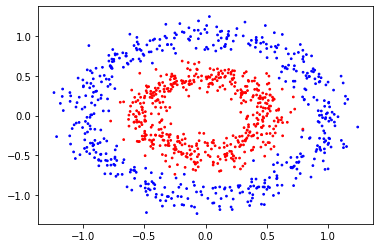

In [51]:
X_train, y_train = make_circles(1000, noise=0.1, factor=0.5, random_state=23)
X_val, y_val = make_circles(1000, noise=0.1, factor=0.5, random_state=42)
plt.scatter(*X_train.T, s=3, c=np.where(y_train, "red", "blue"));

- Per suddividere oggetti in N classi (quì 2), creiamo una rete neurale con molteplici nodi di output, uno per ciascuna classe
- Addestriamo quindi la rete in modo che il nodo di output corrispondente alla classe giusta dia un valore maggiore degli altri
- Per questo l'output atteso della rete per ciascun input, per ora rappresentato come un singolo valore 0 o 1...

In [52]:
y_train[:5]

array([1, 1, 0, 1, 1])

- ...va rappresentato come un vettore _one-hot_ di due elementi, dove
  - 0 (punti esterni) si codifica con `[1, 0]`
  - 1 (punti interni) si codifica con `[0, 1]`
- Questa rappresentazione è utilizzabile con qualsiasi numero di classi
  - ad es. la quarta di 5 classi sarebbe codificata con `[0, 0, 0, 1, 0]`

- Keras fornisce un'apposita funzione `to_categorical` per codificare l'output in questo modo

In [53]:
from keras.utils import to_categorical
yt_train = to_categorical(y_train)
yt_val = to_categorical(y_val)

- Otteniamo così le coppie di valori corrispondenti ai valori attesi dei due nodi di output della rete in ciascun caso

In [54]:
yt_train[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

- Addestriamo un modello con uno strato nascosto di 8 nodi con attivazione ReLU
  - specifichiamo che i valori in input sono 2, le coordinate del punto
- Nello strato di output utilizziamo due nodi, uno per classe
- La funzione di attivazione `softmax` fa in modo che l'output della rete costituisca una distribuzione di probabilità tra le due classi, ovvero che la somma dei due valori sia sempre 1

In [55]:
model = Sequential([
    Dense(8, activation="relu", input_dim=2),
    Dense(2, activation="softmax")
])

- Nel modello abbiamo così un totale di 42 parametri
  - 2x8 = 16 pesi e 8 bias nello strato nascosto
  - 8x2 = 16 pesi e 2 bias nello strato di output

In [56]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 18        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


- Per la classificazione, impostiamo `categorical_crossentropy` come misura dell'errore
  - l'errore è tanto più alto quanto più la probabilità stimata per la classe corretta si allontana da 100\%
- In aggiunta alla metrica dell'errore da ottimizzare, possiamo aggiungere altre metriche di valutazione che vogliamo misurare (`metrics`)
  - calcoliamo l'`accuracy`, ovvero la percentuale di esempi classificati correttamente

In [57]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

- Addestriamo quindi la rete, passando i valori in input (le coordinate dei punti) e quelli in output (le classi nel formato one-hot encoded)

In [58]:
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=20)

Epoch 1/20
1000/1000 [==============================] - 0s 122us/step - loss: 0.7468 - accuracy: 0.4820
Epoch 2/20
1000/1000 [==============================] - 0s 62us/step - loss: 0.7079 - accuracy: 0.4500
[...]
1000/1000 [==============================] - 0s 63us/step - loss: 0.4042 - accuracy: 0.9410
Epoch 20/20
1000/1000 [==============================] - 0s 64us/step - loss: 0.3869 - accuracy: 0.9530


- In `fit_history` troviamo salvato l'andamento sia dell'errore che dell'accuratezza sul training set

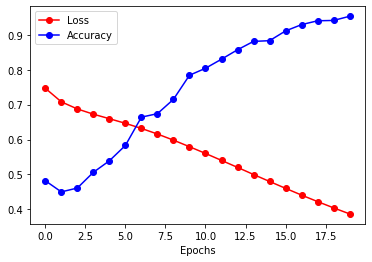

In [59]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["accuracy"], "bo-")
plt.legend(["Loss", "Accuracy"])
plt.xlabel("Epochs");

- Con `predict` otteniamo l'output "grezzo" della rete a fronte di input dati, ovvero le probabilità delle due classi
  - si ottiene anche con `predict_proba` per compatibilità con scikit-learn

In [60]:
model.predict(X_val[:5])

array([[0.35369602, 0.64630395],
       [0.33684295, 0.66315705],
       [0.5574101 , 0.44258982],
       [0.4332674 , 0.5667326 ],
       [0.84208035, 0.15791966]], dtype=float32)

- Per ottenere direttamente le classi predette (le più probabili), possiamo usare il metodo `predict_classes`

In [61]:
model.predict_classes(X_val[:5])

array([1, 1, 0, 1, 0])

- Con `evaluate` calcoliamo tutte le misure indicate in `compile`, ovvero la cross entropy e l'accuratezza

In [62]:
model.evaluate(X_val, yt_val)

1000/1000 [==============================] - 0s 30us/step


[0.3818808979988098, 0.9539999961853027]

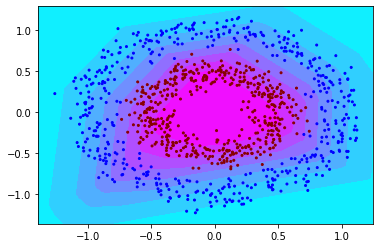

In [63]:
plot_class_model(X_val, y_val, model)

## Esercizio 2: Classificazione in Keras

- **(2a)** Definire, addestrare e calcolare l'accuratezza di un modello a rete neurale come quello sopra ma con 32 nodi nello strato nascosto invece di 8
- **(2b)** Definire, addestrare e calcolare l'accuratezza di un modello a rete neurale con due strati nascosti rispettivamente di 32 e 8 nodi, entrambi con attivazione ReLU
- Quesito: quanti parametri addestrabili ha ciascuno di questi due modelli? (rispondere senza utilizzare `summary`)

In [65]:
model = Sequential([
    Dense(32, activation="relu", input_dim=2),
    Dense(2, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=10)
model.evaluate(X_val, yt_val)

Epoch 1/10
1000/1000 [==============================] - 0s 124us/step - loss: 0.7221 - accuracy: 0.4450
Epoch 2/10
1000/1000 [==============================] - 0s 65us/step - loss: 0.6653 - accuracy: 0.4750
Epoch 3/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.6219 - accuracy: 0.5950
Epoch 4/10
1000/1000 [==============================] - 0s 72us/step - loss: 0.5751 - accuracy: 0.7510
Epoch 5/10
1000/1000 [==============================] - 0s 73us/step - loss: 0.5269 - accuracy: 0.9280
Epoch 6/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.4751 - accuracy: 0.9630
Epoch 7/10
1000/1000 [==============================] - 0s 71us/step - loss: 0.4226 - accuracy: 0.9790
Epoch 8/10
1000/1000 [==============================] - 0s 70us/step - loss: 0.3712 - accuracy: 0.9810
Epoch 9/10
1000/1000 [==============================] - 0s 71us/step - loss: 0.3236 - accuracy: 0.9900
Epoch 10/10
1000/1000 [==============================] - 0s 30us/step


[0.2690431609153748, 0.9890000224113464]

In [67]:
model = Sequential([
    Dense(32, activation="relu", input_dim=2),
    Dense(8, activation="relu"),
    Dense(2, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
fit_history = model.fit(X_train, yt_train, batch_size=10, epochs=10)
model.evaluate(X_val, yt_val)

Epoch 1/10
1000/1000 [==============================] - 0s 161us/step - loss: 0.6895 - accuracy: 0.5010
Epoch 2/10
1000/1000 [==============================] - 0s 74us/step - loss: 0.6474 - accuracy: 0.5350
Epoch 3/10
1000/1000 [==============================] - 0s 81us/step - loss: 0.5691 - accuracy: 0.7480
Epoch 4/10
1000/1000 [==============================] - 0s 75us/step - loss: 0.4525 - accuracy: 0.8940
Epoch 5/10
1000/1000 [==============================] - 0s 80us/step - loss: 0.3275 - accuracy: 0.9680
Epoch 6/10
1000/1000 [==============================] - 0s 78us/step - loss: 0.2238 - accuracy: 0.9860
Epoch 7/10
1000/1000 [==============================] - 0s 64us/step - loss: 0.1515 - accuracy: 0.9910
Epoch 8/10
1000/1000 [==============================] - 0s 61us/step - loss: 0.1117 - accuracy: 0.9940
Epoch 9/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0822 - accuracy: 0.9930
Epoch 10/10
1000/1000 [==============================] - 0s 26us/step


[0.05815823146700859, 0.9929999709129333]

## Caso di studio: Predizione vendite

- I negozi sono interessati a prevedere quanto più accuratamente possibile le vendite giornaliere
  - per ottimizzare le scorte di magazzino, il personale da impiegare, ecc.
- Le vendite sono influenzate da diversi fattori
  - giorno della settimana, festività, promozioni, ...
- In questo caso di studio analizziamo dati relativi a più di 1.000 negozi della catena europea Rossmann
- La predizione su questi dati è stata oggetto di una competizione su Kaggle: https://www.kaggle.com/c/rossmann-store-sales
  - i dati che forniamo sono versioni già parzialmente preprocessate di quelli originali su Kaggle

## Dataset

- I dati sono forniti divisi in due file, per addestramento e validazione

In [69]:
download("rossmann_train.csv.gz", "https://github.com/datascienceunibo/dialab2019/raw/master/Deep_Learning/rossmann_train.csv.gz")
download("rossmann_valid.csv.gz", "https://github.com/datascienceunibo/dialab2019/raw/master/Deep_Learning/rossmann_valid.csv.gz")

- Carichiamo i due file e vediamone la quantità di osservazioni

In [70]:
data_train = pd.read_csv("rossmann_train.csv.gz",
                         parse_dates=["Date"], compression="gzip")

In [71]:
data_val = pd.read_csv("rossmann_valid.csv.gz",
                       parse_dates=["Date"], compression="gzip")

In [72]:
len(data_train), len(data_val)

(804056, 40282)

- Vediamo un estratto dei due frame

In [73]:
data_train.head(4)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Customers,Sales
0,314,2015-06-19,1,0,0,1,1,3560.0,10.0,2001.0,1,31.0,2013.0,164.0,22.50,0,562,5032
1,458,2015-06-19,1,0,0,3,1,3390.0,0.0,0.0,0,0.0,0.0,24186.0,24186.25,0,688,7362
2,961,2015-06-19,1,0,0,4,3,9430.0,0.0,0.0,0,0.0,0.0,24186.0,24186.25,0,768,7764
3,132,2015-06-19,1,0,0,4,3,1040.0,0.0,0.0,1,27.0,2012.0,24186.0,35.50,0,692,7964


In [74]:
data_val.head(4)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Customers,Sales
0,1,2015-07-31,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75,0,555,5263
1,747,2015-07-31,1,0,1,3,3,45740.0,8.0,2008.0,0,0.0,0.0,83.0,24187.75,0,826,10708
2,772,2015-07-31,1,0,1,4,3,1850.0,0.0,0.0,0,0.0,0.0,24187.0,24187.75,0,635,5224
3,752,2015-07-31,1,0,1,1,1,970.0,3.0,2013.0,1,31.0,2013.0,28.0,24.00,0,565,7763


## Descrizione variabili

- Ogni riga è un'osservazione relativa ad un singolo negozio in una certa data, indicati dalle colonne `Store` e `Date`
- Le ultime due colonne `Customers` and `Sales` indicano rispettivamente il numero di clienti e il ricavo totale delle vendite per quel giorno in quel negozio
- Le altre colonne riportano informazioni note a priori relative a negozio e giorno
  - applicazione di promozioni (`Promo*`, `IsPromoMonth`)
  - festività (`StateHoliday`, `SchoolHoliday`)
  - tipologia di negozio (`StoreType`, `Assortment`)
  - distanza da negozi concorrenti e loro data di apertura (`Competition*`)
- L'obiettivo è prevedere da queste informazioni il ricavo totale (`Sales`)
- Definiamo le serie `y_*` con i valori di `Sales` per training e validation set

In [75]:
y_train = data_train["Sales"]
y_val = data_val["Sales"]

- Il ricavo totale `Sales` è ovviamente strettamente proporzionale al numero di clienti `Customers`
  - selezioniamo con `sample(N)` un numero limitato di campioni casuali per creare il grafico con più efficienza

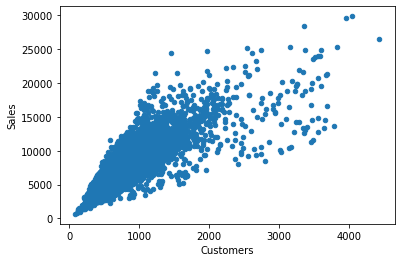

In [76]:
data_train.sample(10000).plot.scatter("Customers", "Sales");

- Non possiamo però usare la variabile `Customers` nella predizione, in quanto proprio come `Sales` non è un'informazione nota a priori

## Selezione e preprocessamento delle variabili

- Eseguiamo una selezione delle variabili da utilizzare per la predizione
- Iniziamo da tutte le variabili con un valore propriamente numerico
  - distanza dalla concorrenza, da quanto tempo è in corso una promozione, ...
- Includiamo anche le variabili binarie 0/1, che sono trattabili come tali
  - se sono in corso delle promozioni, se è giorno di chiusura delle scuole, ...
- Definiamo una lista di tali variabili...

In [77]:
numeric_cols = ["Promo", "SchoolHoliday", "CompetitionDistance",
                "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear",
                "Promo2", "Promo2SinceWeek", "Promo2SinceYear",
                "CompetitionOpen", "PromoOpen", "IsPromoMonth"]

- ...e creiamo due nuovi frame `X_*` selezionando le colonne appropriate
  - `copy()` crea una copia indipendente dei dati, serve per poter aggiungere delle ulteriori colonne

In [78]:
X_train = data_train[numeric_cols].copy()
X_val = data_val[numeric_cols].copy()

- La data di riferimento (`Date`) non può essere usata direttamente come variabile
  - il modello andrà utilizzato in date successive, per cui è impossibile che il modello sia addestrato
- Possiamo però usare come variabili dei campi dalla data, quali il mese o il giorno della settimana
  - così il modello può apprendere ad es. ricorrenze settimanali o annuali
- Creiamo una funzione `add_date_fields` per aggiungere tali variabili ed applichiamola sia al training che al validation set

In [79]:
def add_date_fields(date, dest):
    dest["Day"] = date.dt.day
    dest["Month"] = date.dt.month
    dest["DayOfWeek"] = date.dt.dayofweek
    dest["WeekOfYear"] = date.dt.weekofyear

add_date_fields(data_train["Date"], X_train)
add_date_fields(data_val["Date"], X_val)

- Nei dati abbiamo anche le seguenti tre colonne categoriche, i cui valori sono codificati in modo numerico

In [80]:
categorical_cols = ["StateHoliday", "StoreType", "Assortment"]

In [81]:
for col in categorical_cols:
    print(col, data_train[col].unique())

StateHoliday [0 1 2 3]
StoreType [1 3 4 2]
Assortment [1 3 2]


- Considerando le colonne con questa codifica, il modello assumerebbe un ordinamento e delle similarità tra i diversi valori che non esistono
  - ad es. si assumerebbe erroneamente che lo `StoreType` 1 sia più simile al 2 che al 4
- Possiamo rappresentare tali variabili col _one-hot encoding_, già visto sopra per rappresentare le classi
  - ad es. lo `StoreType` 1 si rappresenterebbe con `[1, 0, 0, 0]`, mentre il 4 con `[0, 0, 0, 1]`
  - in questo modo un modello può apprendere un peso specifico per ciascuno `StoreType`

- scikit-learn fornisce il filtro `OneHotEncoder` per effettuare la codifica one-hot dei dati
- Creiamo un'istanza del filtro specificando
  - `categories="auto"` per applicarlo a tutte le colonne passate determinando in automatico i valori possibili
  - `sparse=False` per creare un array standard piuttosto che una matrice sparsa (lo facciamo solo per poter visualizzare i valori risultanti)

In [82]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories="auto", sparse=False)

- Applichiamo quindi il filtro usando come al solito i metodi `fit_transform` e `transform`, passando solamente le colonne d'interesse

In [83]:
X_train_cat = ohe.fit_transform(data_train[categorical_cols])
X_val_cat = ohe.transform(data_val[categorical_cols])

- Otteniamo matrici con una colonna per ciascun valore possibile delle tre variabili categoriche considerate (4+4+3=11 colonne)

In [84]:
X_train_cat

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

- Usiamo `np.hstack` per concatenare queste matrici a quelle corrispondenti con le variabili numeriche

In [85]:
X_train = np.hstack([X_train.values, X_train_cat])
X_val = np.hstack([X_val.values, X_val_cat])

- Eseguiamo infine la standardizzazione delle variabili, sia X che y, tramite `StandardScaler` come sopra

In [86]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train[:, None]).ravel()
y_val = scaler_y.transform(y_val[:, None]).ravel()

## Modelli di regressione semplici

- Testiamo come baseline un modello di regressione lineare

In [87]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train);

- Con `score` calcoliamo l'accuratezza calcolata col coefficiente R²

In [88]:
model.score(X_val, y_val)

0.2473621241750099

- Nella competizione Kaggle viene usata come misura di riferimento il _Root Mean Squared Percentage Error_ (RMSPE)
$$ \textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2} $$
- Definiamo una funzione `rmspe` per calcolare tale metrica dati i valori attesi e le predizioni, avendo cura di riportare i valori standardizzati nella scala originale

In [89]:
def rmspe(y_real, y_pred):
    y_real = scaler_y.inverse_transform(y_real)
    y_pred = scaler_y.inverse_transform(y_pred)
    return np.sqrt(np.mean((y_pred/y_real-1) ** 2))

- Il modello di regressione lineare ottiene un RMSPE pari a...

In [90]:
rmspe(y_val, model.predict(X_val))

0.4980954590957005

- Possiamo ottenere RMSPE migliori (inferiori) con modelli più complessi, ad es. con variabili di secondo grado e regolarizzazione...

In [91]:
from sklearn.linear_model import Ridge
model = Pipeline([
    ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
    ("model", Ridge(alpha=0.01))
])
model.fit(X_train, y_train)
rmspe(y_val, model.predict(X_val))

0.45752865394327924

## Regressione con reti neurali

- Vediamo i risultati ottenibili con reti neurali
- Iniziamo da una rete con un singolo strato nascosto con attivazione ReLU
- Per la dimensione dell'input leggiamo direttamente il numero di colonne di X

In [92]:
model = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

- Vediamo come in un problema reale come questo il numero di parametri da addestrare sia sull'ordine delle migliaia

In [93]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               3456      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
804056/804056 [==============================] - 6s 7us/step - loss: 0.6966
Epoch 2/5
804056/804056 [==============================] - 6s 7us/step - loss: 0.6283
Epoch 3/5
804056/804056 [==============================] - 6s 8us/step - loss: 0.5950
Epoch 4/5
804056/804056 [==============================] - 6s 8us/step - loss: 0.5776
Epoch 5/5
804056/804056 [==============================] - 6s 8us/step - loss: 0.5647


- Dati dei valori in input, con `predict` otteniamo i valori predetti (normalizzati)

In [95]:
model.predict(X_val[:5])

array([[0.58571124],
       [1.1631502 ],
       [0.18583786],
       [0.3169362 ],
       [0.66970515]], dtype=float32)

- Calcoliamo l'RMSPE dalle predizioni come visto sopra

In [96]:
rmspe(y_val, model.predict(X_val).ravel())

0.37028493779142124

- Testiamo ora una rete con 3 strati nascosti con diversi numeri di nodi
  - ogni strato idealmente corrisponde ad una rappresentazione diversa dell'input

In [97]:
model = Sequential([
    Dense(512, activation="relu", input_dim=X_train.shape[1]),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

- Per via dei molteplici strati, il numero di parametri da addestrare aumenta sensibilmente

In [98]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               13824     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_20 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 83,649
Trainable params: 83,649
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
804056/804056 [==============================] - 15s 18us/step - loss: 0.6058
Epoch 2/5
804056/804056 [==============================] - 15s 18us/step - loss: 0.4267
Epoch 3/5
804056/804056 [==============================] - 15s 19us/step - loss: 0.3471
Epoch 4/5
804056/804056 [==============================] - 15s 18us/step - loss: 0.3155
Epoch 5/5
804056/804056 [==============================] - 15s 18us/step - loss: 0.2947


In [100]:
rmspe(y_val, model.predict(X_val).ravel())

0.2536405390918825

- Siamo così riusciti a migliorare il RMSPE rispetto ai modelli di regressione semplici
  - I risultati sono ulteriormente migliorabili aumentando le epoche di addestramento

## Regolarizzazione

- Nelle reti neurali si possono introdurre diversi accorgimenti per evitare l'overfitting
- Come in altri modelli, possiamo utilizzare la regolarizzazione per evitare che i parametri del modello assumano valori elevati
- I tipi di regolarizzazione applicabili sono `l2` (ridge), `l1` (lasso) o entrambe (elastic net)
- La regolarizzazione può essere applicata sui pesi (_kernel_), sui bias e/o sull'output della funzione di attivazione (_activity_)
- Nell'esempio seguente riprendiamo la rete con un singolo strato nascosto applicando la regolarizzazione L2 ai pesi

In [101]:
from keras.regularizers import l2
model = Sequential([
    Dense(128, activation="relu", kernel_regularizer=l2(0.001), input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [102]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
804056/804056 [==============================] - 5s 7us/step - loss: 0.7190
Epoch 2/5
804056/804056 [==============================] - 5s 7us/step - loss: 0.6592
Epoch 3/5
804056/804056 [==============================] - 6s 7us/step - loss: 0.6356
Epoch 4/5
804056/804056 [==============================] - 6s 7us/step - loss: 0.6253
Epoch 5/5
804056/804056 [==============================] - 6s 7us/step - loss: 0.6166


In [103]:
rmspe(y_val, model.predict(X_val).ravel())

0.38145466858585236

## Dropout

- Il _dropout_, applicato nell'addestramento della rete, azzera ad ogni batch alcuni input casuali in uno strato
  - in fase di predizione (inferenza) non cambia nulla
- In questo modo la rete si addestra su informazioni incomplete, con possibile riduzione dell'overfitting
- Riprendiamo come esempio la rete con tre strati nascosti usata sopra
- Introduciamo dopo il primo strato nascosto uno strato `Dropout`, in cui specifichiamo la frazione di input da azzerare (ad es 10\%)
  - lo strato dropout è "astratto", non introduce nuovi nodi o nuovi parametri da addestrare

In [104]:
from keras.layers import Dropout
model = Sequential([
    Dense(512, activation="relu", input_dim=X_train.shape[1]),
    Dropout(0.1),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [105]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               13824     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_26 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 83,649
Trainable params: 83,649
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
804056/804056 [==============================] - 17s 21us/step - loss: 0.6293
Epoch 2/5
804056/804056 [==============================] - 17s 21us/step - loss: 0.4779
Epoch 3/5
804056/804056 [==============================] - 17s 21us/step - loss: 0.4062
Epoch 4/5
804056/804056 [==============================] - 17s 21us/step - loss: 0.3717
Epoch 5/5
804056/804056 [==============================] - 17s 21us/step - loss: 0.3483


In [107]:
rmspe(y_val, model.predict(X_val).ravel())

0.28430427621178017

- Si noti come l'errore sul training set rimanga leggermente più alto rispetto al modello senza dropout, ma il RMSPE sul validation set è simile

## Proposte di esercizio

Testare sullo stesso problema altre configurazioni di reti neurali
- modificando il numero di strati e di nodi in essi
- introducendo diversi tipi di regolarizzazione con diversa intensità in diversi strati
- introducendo il dropout con diversa intensità in diversi strati
- cambiando il numero di epoche o la batch size

Consultare la [guida di Keras](https://keras.io/api/) per dettagli su queste e altre opzioni (altre funzioni di attivazione, inizializzazione dei pesi, algoritmi di ottimizzazione e relative opzioni, ...)